In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [15]:
df=pd.read_csv("./Churn_Modelling.csv")

In [16]:
df.shape

(10000, 14)

In [17]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Surname : The surname of the customer
CreditScore : The credit score of the customer
Geography : The country of the customer(Germany/France/Spain)
Gender : The gender of the customer (Female/Male)
Age : The age of the customer
Tenure : The customer's number of years in the in the bank
Balance : The customer's account balance
NumOfProducts : The number of bank products that the customer uses
HasCrCard : Does the customer has a card? (0=No, 1=Yes)
IsActiveMember : Does the customer has an active mebership (0=No, 1=Yes)
EstimatedSalary : The estimated salary of the customer
Exited : Churned or not? (0=No, 1=Yes)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [19]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [20]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Axes(0.125,0.11;0.62x0.77)


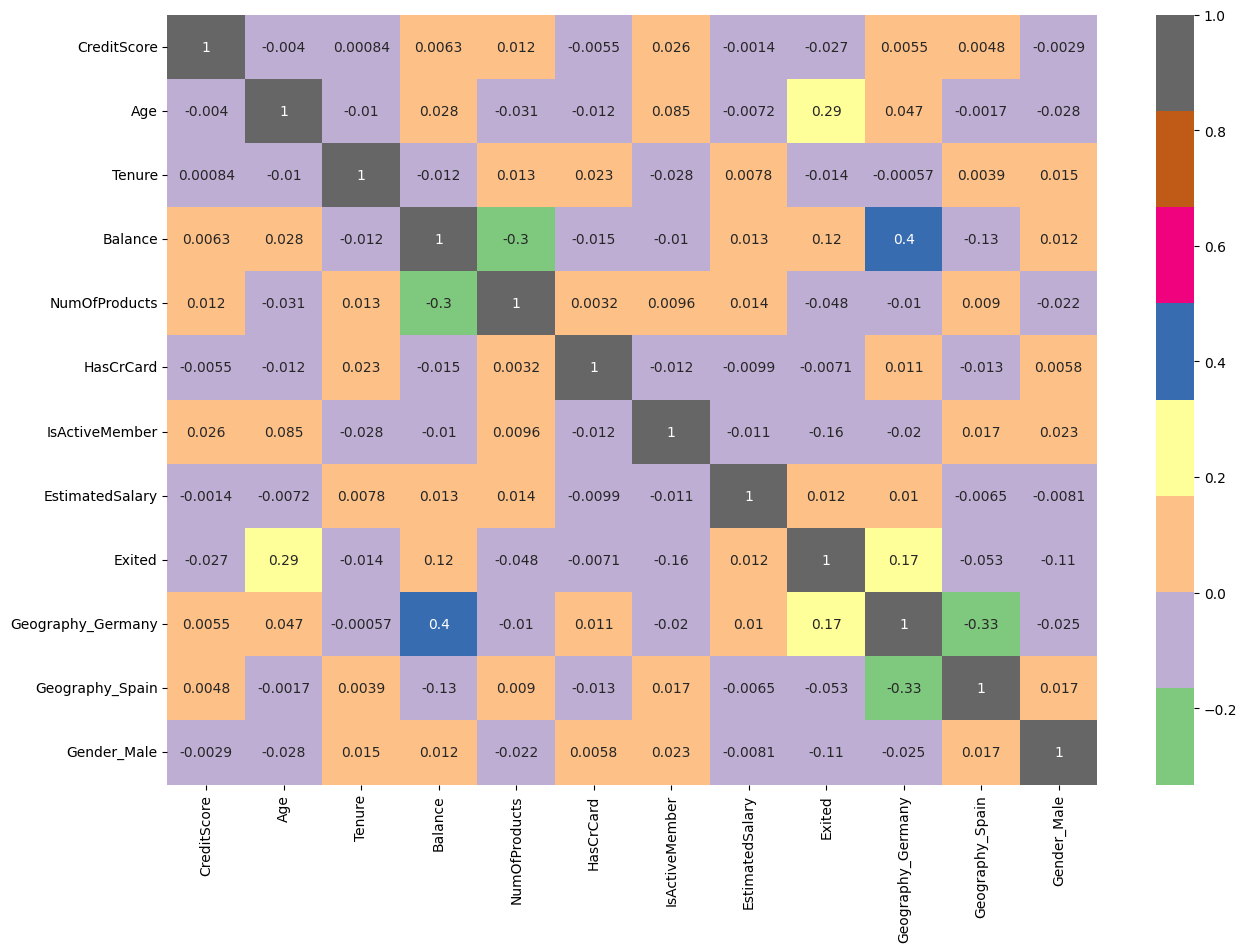

In [34]:
# Drop RowNumber, CustomerId, and Surname
df_processed = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1)
df_encoded = pd.get_dummies(df_processed, columns=['Geography', 'Gender'], drop_first=True, dtype=int)
# Calculate the correlation matrix now that all columns are numeric
plt.figure(figsize=(15,10))
corr = df_encoded.corr()
correlation_matrix = sns.heatmap(corr, annot=True, cmap="Accent")

print(correlation_matrix)

In [38]:
features=corr['Exited'].sort_values(ascending=False)[1:]

In [39]:
features.index

Index(['Age', 'Geography_Germany', 'Balance', 'EstimatedSalary', 'HasCrCard',
       'Tenure', 'CreditScore', 'NumOfProducts', 'Geography_Spain',
       'Gender_Male', 'IsActiveMember'],
      dtype='object')

In [40]:
features.values

array([ 0.28532304,  0.17348787,  0.11853277,  0.01209686, -0.00713777,
       -0.01400061, -0.02709354, -0.04781986, -0.05266676, -0.10651249,
       -0.15612828])

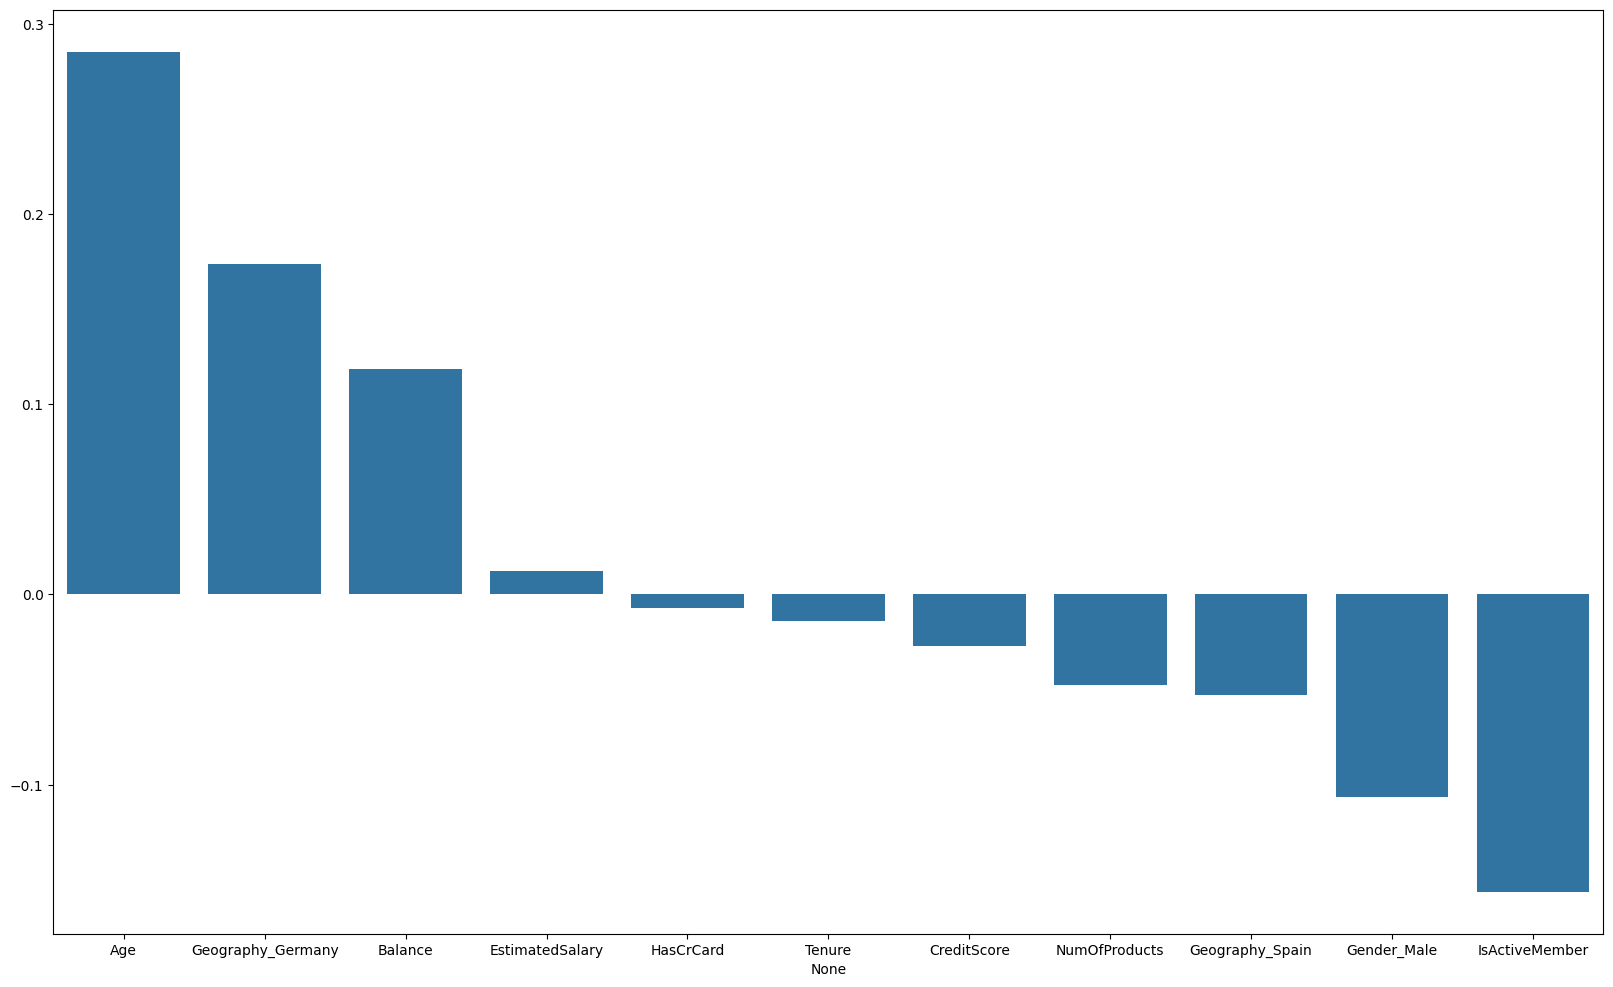

In [42]:
plt.figure(figsize=(20,12))
sns.barplot(x=features.index, y=features.values)
plt.show()

In [43]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Exited
0    7963
1    2037
Name: count, dtype: int64


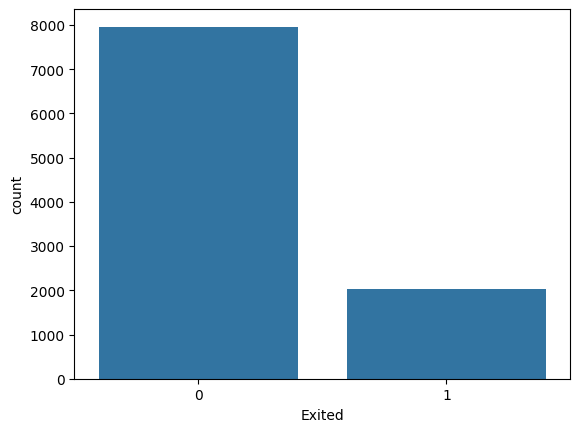

In [45]:
print(df['Exited'].value_counts())

sns.countplot(x='Exited', data=df)
plt.show()

Gender
Male      5457
Female    4543
Name: count, dtype: int64


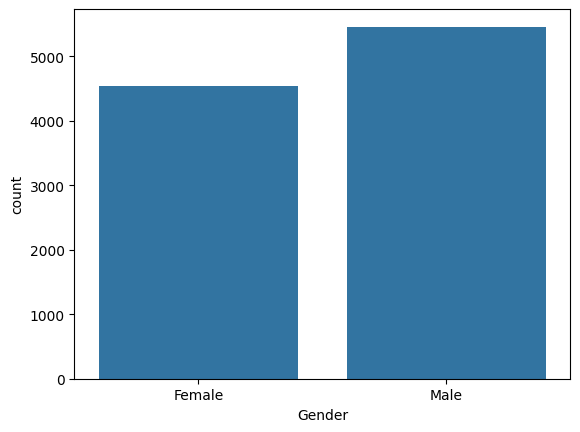

In [46]:
print(df['Gender'].value_counts())

sns.countplot(x='Gender', data=df)
plt.show()

Tenure
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: count, dtype: int64


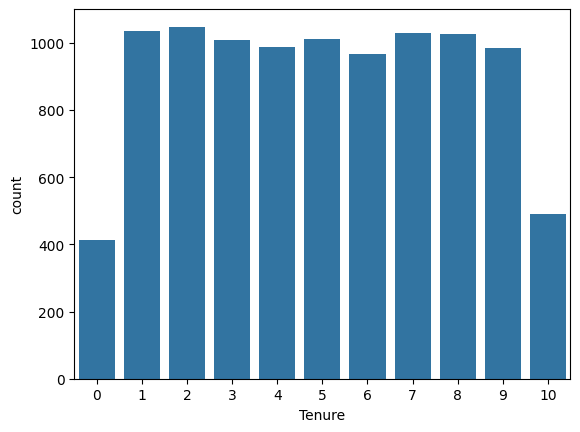

In [47]:
print(df['Tenure'].value_counts())

sns.countplot(x='Tenure', data=df)
plt.show()

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64


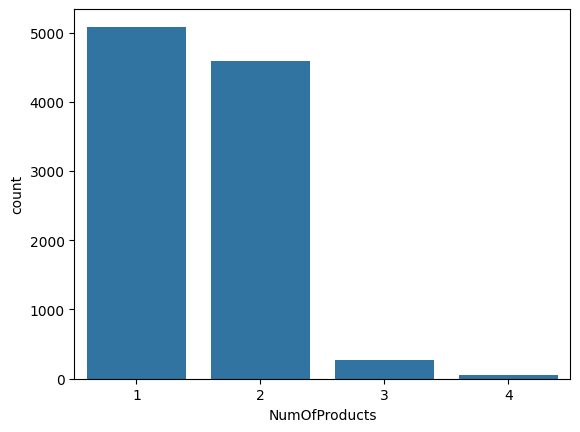

In [48]:
print(df['NumOfProducts'].value_counts())

sns.countplot(x='NumOfProducts', data=df)
plt.show()

HasCrCard
1    7055
0    2945
Name: count, dtype: int64


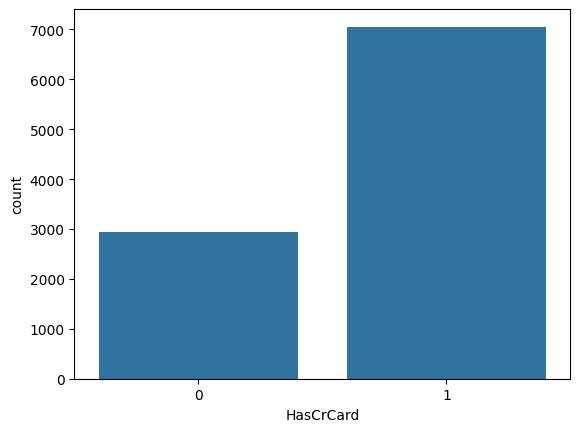

In [49]:
print(df['HasCrCard'].value_counts())

sns.countplot(x='HasCrCard', data=df)
plt.show()

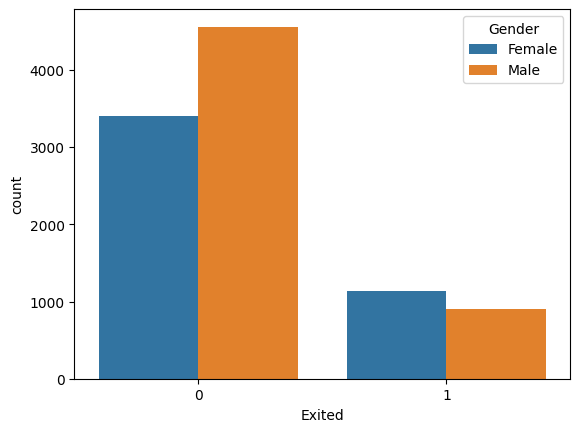

In [51]:
sns.countplot(x='Exited', data= df, hue='Gender')
plt.show()

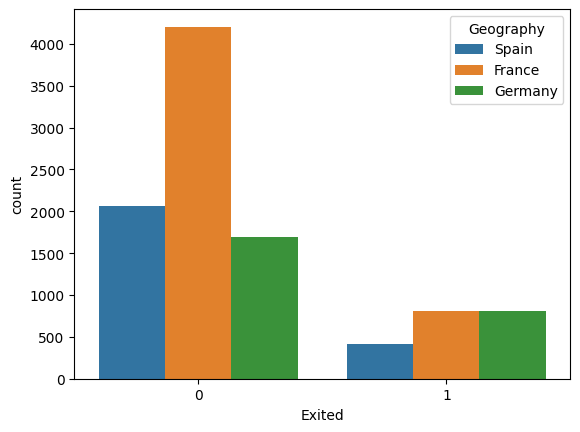

In [53]:
sns.countplot(x='Exited', data= df, hue='Geography')
plt.show()

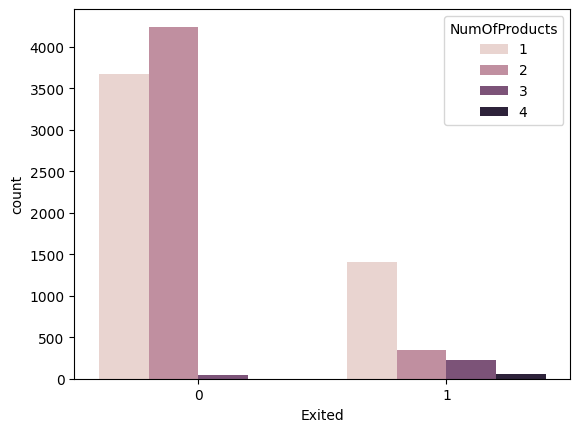

In [54]:
sns.countplot(x='Exited', data= df, hue='NumOfProducts')
plt.show()

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


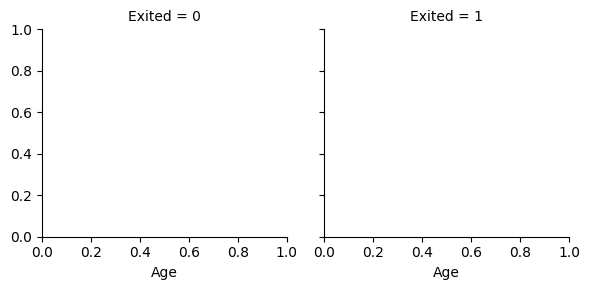

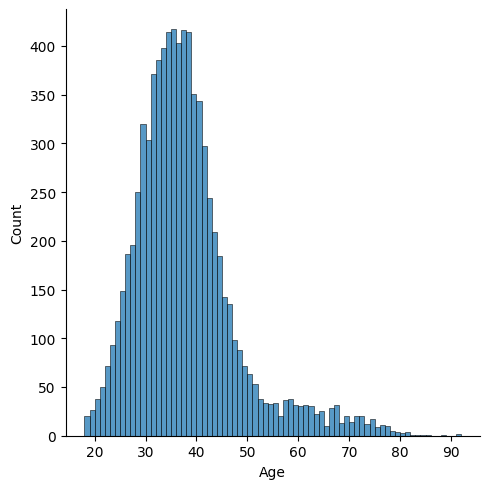

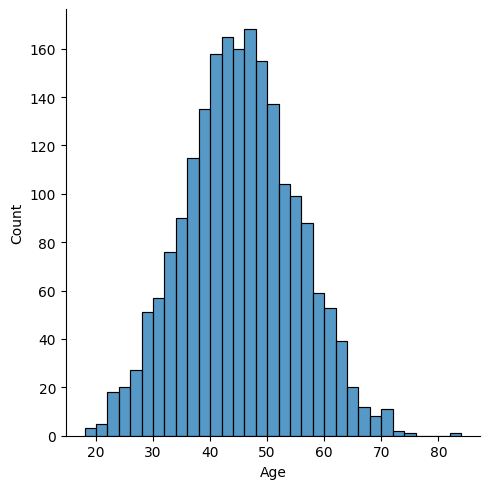

In [58]:
sns.FacetGrid(df, col='Exited')\
    .map(sns.displot, "Age")
plt.show()

In [59]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [60]:
df.drop(columns=['RowNumber', "CustomerId", "Surname"], inplace= True)

In [61]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [65]:
df['Geography']=df['Geography'].astype('category').cat.codes

In [67]:
df['Gender']=np.where(df['Gender']=='Male', 1, 0)

In [70]:
X=df.drop(columns=['Exited']).values
y=df['Exited'].values

In [75]:
X.shape

(10000, 10)

In [74]:
y.shape

(10000,)

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [86]:

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [83]:
basic_model=XGBClassifier()
basic_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [87]:
def evaluate_model(model):
    print ("training accuracy:" , model.score(X_train, y_train))
    print ("testing accuracy:" , model.score(X_test, y_test))

    y_pred=model.predict(X_test)

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("F1 score:", f1_score(y_test, y_pred))

In [88]:
evaluate_model(basic_model)

training accuracy: 0.9644776119402985
testing accuracy: 0.8563636363636363
[[2499  158]
 [ 316  327]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      2657
           1       0.67      0.51      0.58       643

    accuracy                           0.86      3300
   macro avg       0.78      0.72      0.75      3300
weighted avg       0.85      0.86      0.85      3300

F1 score: 0.5797872340425532


In [90]:
from sklearn.model_selection import GridSearchCV

In [ ]:
xgb_params={
    'n_estimators':[100,200]
    'max_depth' :[4,5]
}

In [93]:
grid= GridSearchCV(XGBClassifier(), param_grid=xgb_params, scoring='accuracy',cv=10 )
grid.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'n_estimators': [100, 200, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [ ]:
print("Best score", grid.best_score_)

In [95]:
print("Best score", grid.best_params_)

Best score {'n_estimators': 100}


In [96]:
model_1=XGBClassifier(max_depth=4)
model_1.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [97]:
evaluate_model(model_1)

training accuracy: 0.9056716417910448
testing accuracy: 0.8681818181818182
[[2544  113]
 [ 322  321]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2657
           1       0.74      0.50      0.60       643

    accuracy                           0.87      3300
   macro avg       0.81      0.73      0.76      3300
weighted avg       0.86      0.87      0.86      3300

F1 score: 0.596100278551532


In [99]:
350+85
from sklearn.ensemble import GradientBoostingClassifier

In [100]:
model_2= GradientBoostingClassifier(n_estimators=500)
model_2.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [101]:
evaluate_model(model_2)

training accuracy: 0.9073134328358209
testing accuracy: 0.8693939393939394
[[2546  111]
 [ 320  323]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2657
           1       0.74      0.50      0.60       643

    accuracy                           0.87      3300
   macro avg       0.82      0.73      0.76      3300
weighted avg       0.86      0.87      0.86      3300

F1 score: 0.5998142989786444
